<a href="https://colab.research.google.com/github/ekourkchi/Springboard_notebooks/blob/master/AutoEncoder_sparse_movieRatings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
# Load a movie metadata dataset
movie_metadata = (pd.read_csv('/content/drive/My Drive/'+ 'movies_metadata.csv', 
                              low_memory=False)[['original_title', 'overview', 'vote_count']]
                    .set_index('original_title')
                    .dropna())

# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Pandora's Promise,"The atomic bomb, the specter of a global nucle..."
Les Aventures extraordinaires d'Adèle Blanc-Sec,An adventure set in the early part of the 20th...
Hot Shots!,"Charlie Sheen, Lloyd Bridges, Cary Elwes, Vale..."
The Belles of St. Trinian's,Story of manic schoolgirls who are more intere...
No manches Frida,A thief gets a job at a school in order to ret...


In [3]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

In [4]:
tfidf_matrix = tfidf_matrix.toarray()

In [5]:
len(movie_metadata)

21604

In [6]:
latent_dim = 20 

class Autoencoder(Model):
    def __init__(self, latent_dim, n_dimension):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.n_dimension = n_dimension

        encoder = tf.keras.models.Sequential(name='encoder')
        # encoder.add(tf.keras.layers.Dense(1000, activation='relu', name='encoder1'))
        encoder.add(tf.keras.layers.Dense(latent_dim, activation='relu', name='encoder2'))
        self.encoder = encoder
#         self.encoder = tf.keras.Sequential([
# #           layers.Flatten(),
#           layers.Dense(1000, activation='relu', name='dense_1'),
#           layers.Dense(latent_dim, activation='relu', name='dense_2'),
#         ])

        decoder = tf.keras.models.Sequential(name='decoder')
        # decoder.add(tf.keras.layers.Dense(20, activation='relu', name='decoder1'))
        decoder.add(tf.keras.layers.Dense(n_dimension, activation='sigmoid', name='decoder2'))
        self.decoder = decoder
#         self.decoder = tf.keras.Sequential([
#           layers.Dense(1000, activation='relu', name='dense_3'),
#           layers.Dense(n_dimension, activation='relu', name='dense_4'),
# #           layers.Reshape((28, 28))
#         ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
print(tfidf_matrix.shape)
print(len(movie_metadata))

(21604, 48083)
21604


In [7]:
tfidf_matrix_train = tfidf_matrix[:20000,:]
tfidf_matrix_test  = tfidf_matrix[20000:,:]

print(tfidf_matrix_train.shape)
print(tfidf_matrix_test.shape)

(20000, 48083)
(1604, 48083)


In [8]:
n_dim = tfidf_matrix_test.shape[1]
n_dim

48083

In [9]:
print(np.min(tfidf_matrix))
print(np.max(tfidf_matrix))
print(np.std(tfidf_matrix))

0.0
1.0
0.004559397919072302


In [10]:
autoencoder = Autoencoder(latent_dim, n_dim) 
autoencoder.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
n_epochs = 15
autoencoder.fit(tfidf_matrix_train, tfidf_matrix_train,
                epochs=n_epochs,
                shuffle=True,
                batch_size=512,
                validation_data=(tfidf_matrix_test, tfidf_matrix_test))


Epoch 1/15
40/40 [==============================] - 3s 80ms/step - loss: 0.4958 - mae: 0.4958 - mse: 0.2459 - val_loss: 0.4902 - val_mae: 0.4902 - val_mse: 0.2403
Epoch 2/15
40/40 [==============================] - 3s 68ms/step - loss: 0.4740 - mae: 0.4740 - mse: 0.2249 - val_loss: 0.4400 - val_mae: 0.4400 - val_mse: 0.1937
Epoch 3/15
40/40 [==============================] - 3s 67ms/step - loss: 0.3637 - mae: 0.3637 - mse: 0.1352 - val_loss: 0.2679 - val_mae: 0.2679 - val_mse: 0.0729
Epoch 4/15
40/40 [==============================] - 3s 68ms/step - loss: 0.1739 - mae: 0.1739 - mse: 0.0336 - val_loss: 0.1082 - val_mae: 0.1082 - val_mse: 0.0131
Epoch 5/15
40/40 [==============================] - 3s 68ms/step - loss: 0.0673 - mae: 0.0673 - mse: 0.0056 - val_loss: 0.0499 - val_mae: 0.0499 - val_mse: 0.0033
Epoch 6/15
40/40 [==============================] - 3s 68ms/step - loss: 0.0329 - mae: 0.0329 - mse: 0.0015 - val_loss: 0.0293 - val_mae: 0.0293 - val_mse: 0.0013
Epoch 7/15
40/40 [====

In [11]:
autoencoder.summary()

for key in autoencoder.history.history:
    print(key)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 20)                961680    
_________________________________________________________________
decoder (Sequential)         (None, 48083)             1009743   
Total params: 1,971,423
Trainable params: 1,971,423
Non-trainable params: 0
_________________________________________________________________
loss
mae
mse
val_loss
val_mae
val_mse


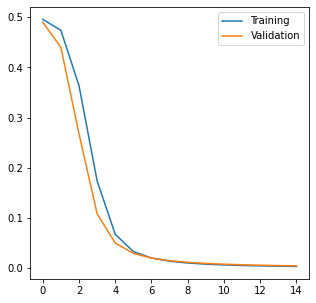

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']

ax.plot(np.arange(n_epochs), loss, label='Training')
ax.plot(np.arange(n_epochs), val_loss, label='Validation')

ax.legend()